# Final Assignment

1. What are the socio-demographic variables we want to use?
    * age  
    * gender 
    * educational attainment  
    * income level  
    * race / ethnicity    

2. Types of models to test:  
    * Logistic regression  
    * Neural network  

3. Outcome variables to predict:  
    * fertility
    * (did you spend time in a hospital) ch07a229; ch08b229; ch09c229; ch10d229; ch11e229; ch12f229; ch13g229; ch15h229; ch16i229; ch17j229; ch18k229; ch19l229; ch20m229  
    * (how would you describe your health 1-5) ch07a004; ch08b004; ch09c004; ch10d004; ch11e004; ch12f004; ch13g004; ch15h004; ch16i004; ch17j004; ch18k004; ch19l004; ch20m004  
    * (is your health better or worse than last year) ch07a005; ch08b005; ch09c005; ch10d005; ch11e005; ch12f005; ch13g005; ch15h005; ch16i005; ch17j005; ch18k005; ch19l005; ch20m005  

4. Build a few comparison models for predicting fertility. Pick the best baseline model, and try with other outcome variables.


## Baseline Model 1: Logistic Regression Model

Here, we predict fertility using a logistic regression model of demographic variables. We compare the accuracy metrics against the models submitted for Assignment 2.

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
import random

In [14]:
# find demographic variables in codebook
codebook = pd.read_csv('codebook/PreFer_codebook_summary.csv') 
# print(codebook.columns)

# see what background variables are in the dataset
background_vars = codebook[codebook['survey'] == 'Background Variables']['var_label_across_waves']
# print(background_vars) # uncomment to see all variables

## variables that could be useful ('var_label_across_waves')
# Level of education in CBS (Statistics Netherlands) categories
# Year of birth [imputed by PreFer organisers]
# Gender [imputed by PreFer organisers]
# Origin [imputed by PreFer organisers]
# Gross household income in Euros

# find the variable names
vars_list = [
    'Level of education in CBS (Statistics Netherlands) categories',
    'Year of birth [imputed by PreFer organisers]',
    'Gender [imputed by PreFer organisers]',
    'Origin [imputed by PreFer organisers]',
    'Gross household income in Euros'
]
filtered_rows = codebook[codebook['var_label_across_waves'].isin(vars_list)]

# show variable labels + names
filtered_rows[['var_label_across_waves', 'var_names']]

,var_label_across_waves,var_names
3276,Year of birth [imputed by PreFer organisers],birthyear_bg
3277,Gender [imputed by PreFer organisers],gender_bg
3278,Origin [imputed by PreFer organisers],migration_background_bg
3281,Gross household income in Euros,brutohh_f_2007; brutohh_f_2008; brutohh_f_2009...
3289,Level of education in CBS (Statistics Netherla...,oplcat_2007; oplcat_2008; oplcat_2009; oplcat_...
3314,Level of education in CBS (Statistics Netherla...,oplcat; oplcat; oplcat; oplcat; oplcat; oplcat...
3321,Gross household income in Euros,brutohh_f; brutohh_f; brutohh_f; brutohh_f; br...
3325,Year of birth [imputed by PreFer organisers],birthyear_imp; birthyear_imp; birthyear_imp; b...
3326,Gender [imputed by PreFer organisers],gender_imp; gender_imp; gender_imp; gender_imp...
3327,Origin [imputed by PreFer organisers],migration_background_imp; migration_background...


In [15]:
# get list of var_names
background_var_names = [
    'nomem_encr',
    'birthyear_imp', # imputed year of birth
    'gender_imp', # imputed gender
    'migration_background_imp', # origin
    'oplcat', # education
    'brutohh_f', # gross household income
    
]

# find demographic variables in codebook
background_data = pd.read_csv('training_data/PreFer_train_background_data.csv') 
# display(background_data[background_var_names].drop_duplicates()) # lots of duplicates and multiple entries due to income over waves

# take mean of income and median education across waves (grouped by unique IDs)
grouped_data = background_data[background_var_names].groupby('nomem_encr').agg({'brutohh_f': 'mean', 'oplcat': 'median'})
grouped_data = grouped_data.reset_index()
# impute NAs with median (this is if data is missing for all waves for this ID)
grouped_data['brutohh_f'] = grouped_data['brutohh_f'].fillna((grouped_data['brutohh_f'].median()))
grouped_data['oplcat'] = grouped_data['oplcat'].fillna((grouped_data['oplcat'].median()))
display(grouped_data.head())

merge_data = background_data[background_var_names[:-2]].drop_duplicates()
# fix NaNs on migration; for simplicity, let's recode to Dutch or not Dutch
# "c(`Dutch background` = 0, `First generation foreign, Western background` = 101, `First generation foreign, non-western background` = 102, `Second generation foreign, Western background` = 201, `Second generation foreign, non-western background` = 202, `Origin unknown or part of the information unknown (missing values)` = 999)",1
merge_data['migration_background_imp'] = np.where(merge_data['migration_background_imp'] > 0, 1, 0) # recode migration data
display(merge_data)

# merge data, this has only one row per unique ID
df = pd.merge(merge_data, grouped_data, on='nomem_encr')
display(df)
print(df.isna().sum()) # no NaNs




,nomem_encr,brutohh_f,oplcat
0,700003,2893.988671,3.0
1,700004,11177.777778,5.0
2,700008,7320.808037,4.0
3,700010,2165.512842,4.0
4,700016,3051.677046,3.0


,nomem_encr,birthyear_imp,gender_imp,migration_background_imp
0,700003,1965,2,0
33,700004,1980,2,0
51,700008,1991,2,0
193,700010,1987,2,0
225,700016,1984,1,1
...,...,...,...,...
758558,733177,1994,2,1
758570,733178,1962,1,0
758679,733179,1992,1,0
758703,733181,1958,1,0


,nomem_encr,birthyear_imp,gender_imp,migration_background_imp,brutohh_f,oplcat
0,700003,1965,2,0,2893.988671,3.0
1,700004,1980,2,0,11177.777778,5.0
2,700008,1991,2,0,7320.808037,4.0
3,700010,1987,2,0,2165.512842,4.0
4,700016,1984,1,1,3051.677046,3.0
...,...,...,...,...,...,...
12849,733177,1994,2,1,5680.000000,4.0
12850,733178,1962,1,0,3763.564356,4.0
12851,733179,1992,1,0,10434.437570,4.0
12852,733181,1958,1,0,4608.940516,5.0


nomem_encr                  0
birthyear_imp               0
gender_imp                  0
migration_background_imp    0
brutohh_f                   0
oplcat                      0
dtype: int64


In [4]:
# is outcome available?
main_data = pd.read_csv('training_data/PreFer_train_data.csv') 

# get IDs that have outcome data
have_outcome = main_data[main_data['outcome_available'] == 1]['nomem_encr']
# display(have_outcome.head())

/var/folders/99/w8jtz3l97r9f018pcnl678l80000gp/T/ipykernel_52451/3783942323.py:2: DtypeWarning: Columns (2583,2584,2585,2586,2587,2588,2589,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4373,4374,4375,4379,4380,4381,4382,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,4400,4401,4405,4406,4407,4408,4409,5215,5216,5219,5220,5613,5614,5615,5616,5617,5618,5619,5620,5621,5622,5624,5625,5626,5627,5628,5629,5630,5631,5632,5633,5634,5635,5636,5638,5639,5640,5787,5788,5789,5790,5791,5792,5793,5794,5795,5796,6393,6394,6395,6396,6397,6398,6399,6400,6401,6402,6403,6619,6620,6621,6622,6623,6624,6625,6626,6627,6628,6629,6630,6631,6632,6633,6634,6635,6638,6640,6641,6642,6643,6644,6645,6646,6647,6648,6649,6650,6651,6652,6653,6654,6655,6656,6657,6658,6659,6660,6661,6664,6666,6667,6668,6669,6670,6965,6966,6967,6968,6969,6970,6971,6972,6973,6974,6975,7064,7065,7066,7067,7068,7069,7070,7071,7072,7073,7074,7163,7164,7165,7166,7167,7168,7169,

In [16]:
# now we have just df of those who have outcome data
subset_df = df[df['nomem_encr'].isin(have_outcome)]

In [17]:
display(subset_df.head())

print(subset_df.isna().sum())

,nomem_encr,birthyear_imp,gender_imp,migration_background_imp,brutohh_f,oplcat
6,700025,2000,2,0,4069.947401,1.0
7,700026,1994,2,0,1230.714131,6.0
18,700050,1979,2,0,8351.851852,5.0
45,700120,1996,1,0,2300.000000,4.0
57,700155,1981,2,0,4027.687373,4.0


nomem_encr                  0
birthyear_imp               0
gender_imp                  0
migration_background_imp    0
brutohh_f                   0
oplcat                      0
dtype: int64


In [19]:
# ready to train lr baseline model
# get outcome data
outcome_data = pd.read_csv('training_data/PreFer_train_outcome.csv')

# set X, y for the model training function
model_df = pd.merge(subset_df, outcome_data[outcome_data['nomem_encr'].isin(have_outcome)], on="nomem_encr")
X = model_df.drop(['new_child', 'nomem_encr'], axis=1)
y = model_df['new_child']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

Precision: 0.825
Recall: 0.773
F Score: 0.680


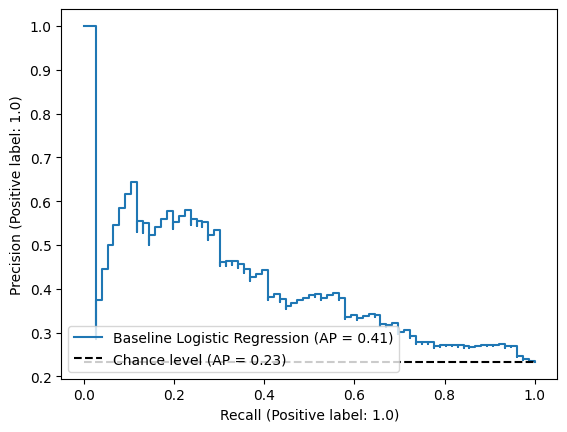

In [207]:
###########################################
# Logistic Regression Baseline Model
###########################################

"""
Baseline model 1 using logistic regression of 5 background variables:
    year of birth
    gender
    origin (recoded as binary Dutch or not Dutch)
    education
    median gross household income across waves

Split train/test at test size = 0.33; chance level = 0.23 (unbalanced)

Results: Baseline model does better than chance
"""


model_baseline_lr = LogisticRegression()

# Fit the model
model_baseline_lr.fit(X_train, y_train)

y_pred = model_baseline_lr.predict(X_test)

precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

from sklearn import metrics
metrics.PrecisionRecallDisplay.from_estimator(
    model_baseline_lr, X_test, y_test, 
    name="Baseline Logistic Regression", 
    plot_chance_level=True)

Precision: 0.588
Recall: 0.767
F Score: 0.666


/Users/jc2822/miniconda543/envs/phi543-NLP-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


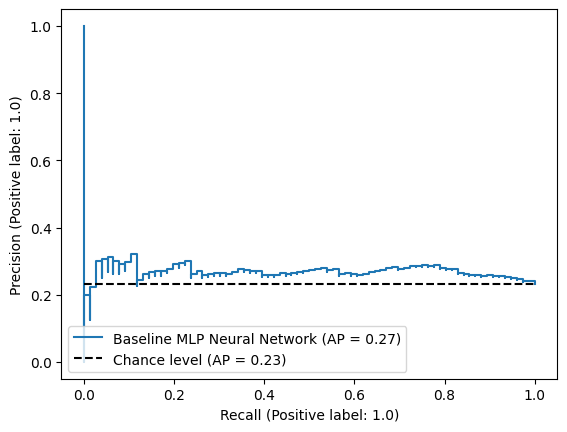

In [26]:
###########################################
# Neural Network Baseline Model
###########################################

from sklearn.neural_network import MLPClassifier
from sklearn import metrics

"""
Baseline model 1 using a Multi-Layer Perceptron Neural Network of 5 background variables:
    year of birth
    gender
    origin (recoded as binary Dutch or not Dutch)
    education
    median gross household income across waves

Split train/test at test size = 0.33; chance level = 0.23 (unbalanced)

Results: Baseline model does slightly better than chance
"""


model_baseline_mlp = MLPClassifier(hidden_layer_sizes=(50,10), random_state=42)

# Fit the model
model_baseline_mlp.fit(X_train, y_train)

y_pred = model_baseline_mlp.predict(X_test)

precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

metrics.PrecisionRecallDisplay.from_estimator(
    model_baseline_mlp, X_test, y_test, 
    name="Baseline MLP Neural Network", 
    plot_chance_level=True)

/var/folders/br/556vkbgd3sx0dxk5j3rczcy80000gn/T/ipykernel_25306/2208491696.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=45, ha='right')


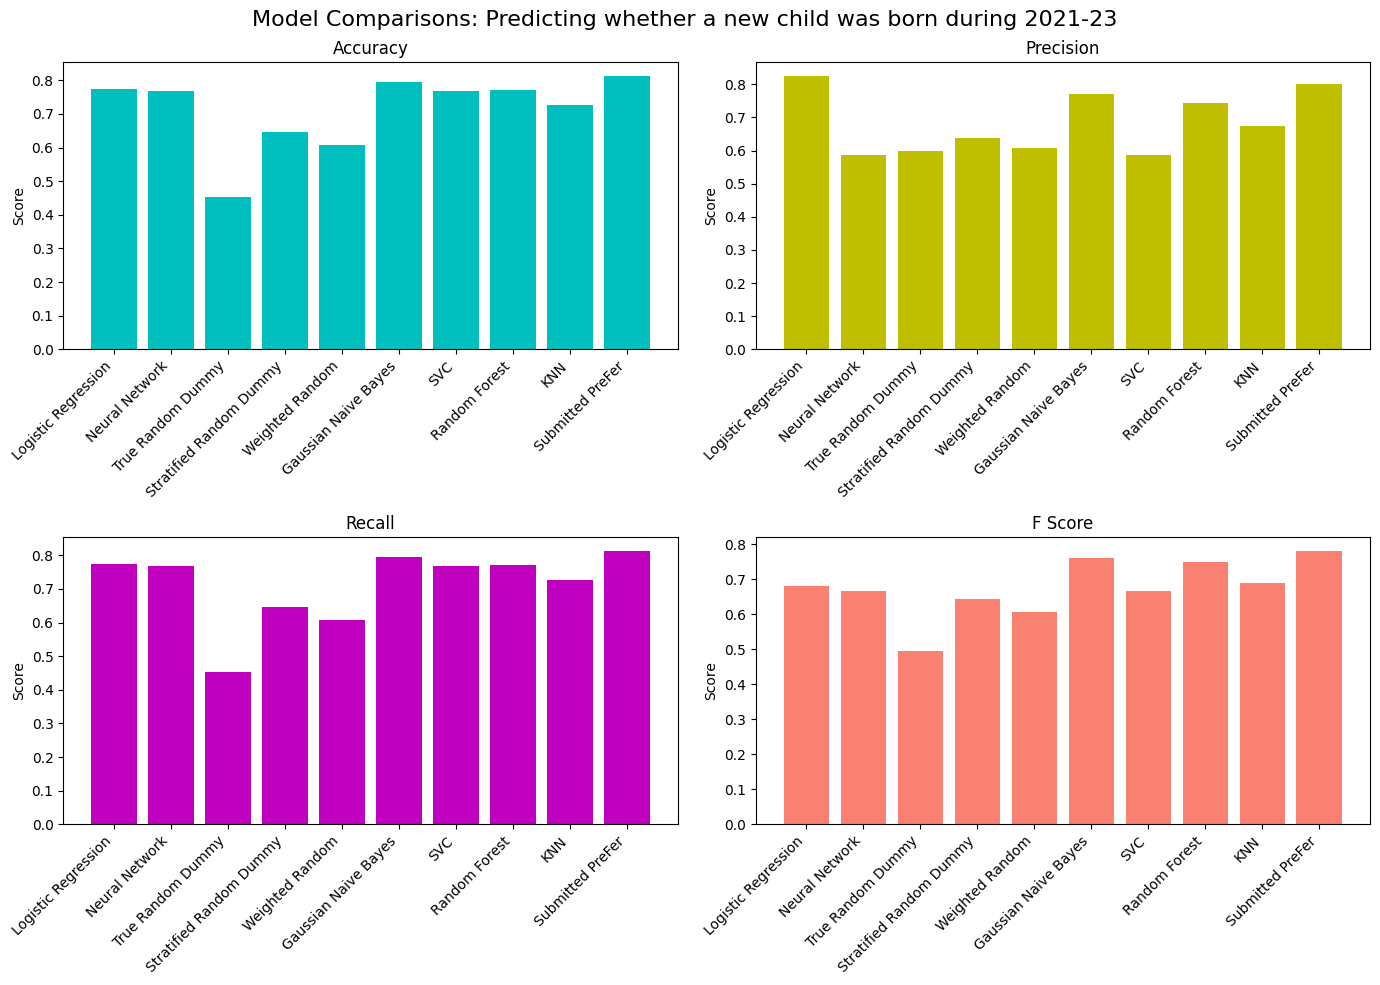

In [45]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Neural Network', 'True Random Dummy', 
          'Stratified Random Dummy', 'Weighted Random', 'Gaussian Naive Bayes', 
          'SVC', 'Random Forest', 'KNN', 'Submitted PreFer']

accuracy = [0.773, 0.767, 0.454, 0.647, 0.607, 0.794, 0.767, 0.770, 0.727, 0.813]
precision = [0.825, 0.588, 0.598, 0.639, 0.607, 0.771, 0.588, 0.743, 0.673, 0.802]
recall = [0.773, 0.767, 0.454, 0.647, 0.607, 0.794, 0.767, 0.770, 0.727, 0.813]
f_score = [0.680, 0.666, 0.496, 0.643, 0.607, 0.762, 0.666, 0.749, 0.690, 0.781]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# add overall title
fig.suptitle('Model Comparisons: Predicting whether a new child was born during 2021-23', fontsize=16)

# Plot Accuracy
axs[0, 0].bar(models, accuracy, color='c')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Score')

# Plot Precision
axs[0, 1].bar(models, precision, color='y')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Score')

# Plot Recall
axs[1, 0].bar(models, recall, color='m')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Score')

# Plot F Score
axs[1, 1].bar(models, f_score, color='salmon')
axs[1, 1].set_title('F Score')
axs[1, 1].set_ylabel('Score')

# Rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()



/var/folders/br/556vkbgd3sx0dxk5j3rczcy80000gn/T/ipykernel_25306/578036753.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


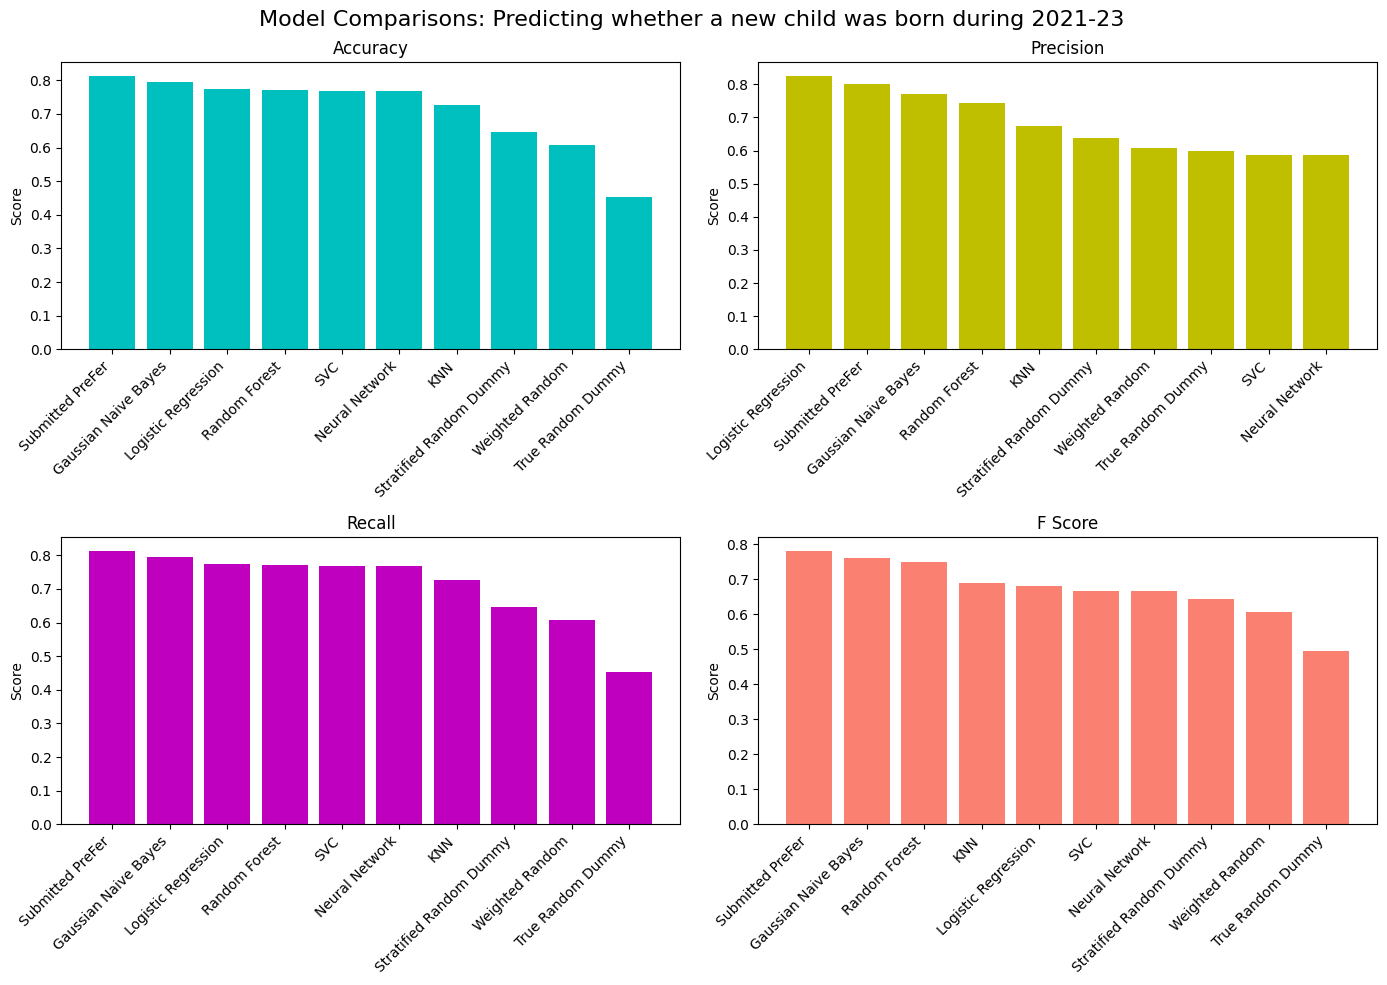

In [44]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Neural Network', 'True Random Dummy', 
          'Stratified Random Dummy', 'Weighted Random', 'Gaussian Naive Bayes', 
          'SVC', 'Random Forest', 'KNN', 'Submitted PreFer']

accuracy = [0.773, 0.767, 0.454, 0.647, 0.607, 0.794, 0.767, 0.770, 0.727, 0.813]
precision = [0.825, 0.588, 0.598, 0.639, 0.607, 0.771, 0.588, 0.743, 0.673, 0.802]
recall = [0.773, 0.767, 0.454, 0.647, 0.607, 0.794, 0.767, 0.770, 0.727, 0.813]
f_score = [0.680, 0.666, 0.496, 0.643, 0.607, 0.762, 0.666, 0.749, 0.690, 0.781]

# Sort the models based on each metric
sorted_models_accuracy = [x for _, x in sorted(zip(accuracy, models), reverse=True)]
sorted_accuracy = sorted(accuracy, reverse=True)

sorted_models_precision = [x for _, x in sorted(zip(precision, models), reverse=True)]
sorted_precision = sorted(precision, reverse=True)

sorted_models_recall = [x for _, x in sorted(zip(recall, models), reverse=True)]
sorted_recall = sorted(recall, reverse=True)

sorted_models_f_score = [x for _, x in sorted(zip(f_score, models), reverse=True)]
sorted_f_score = sorted(f_score, reverse=True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# add overall title
fig.suptitle('Model Comparisons: Predicting whether a new child was born during 2021-23', fontsize=16)

# Plot Accuracy
axs[0, 0].bar(sorted_models_accuracy, sorted_accuracy, color='c')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Score')

# Plot Precision
axs[0, 1].bar(sorted_models_precision, sorted_precision, color='y')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Score')

# Plot Recall
axs[1, 0].bar(sorted_models_recall, sorted_recall, color='m')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Score')

# Plot F Score
axs[1, 1].bar(sorted_models_f_score, sorted_f_score, color='salmon')
axs[1, 1].set_title('F Score')
axs[1, 1].set_ylabel('Score')

# Rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_ranked.png')
plt.show()


/var/folders/br/556vkbgd3sx0dxk5j3rczcy80000gn/T/ipykernel_25306/1333300306.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=45, ha='right')


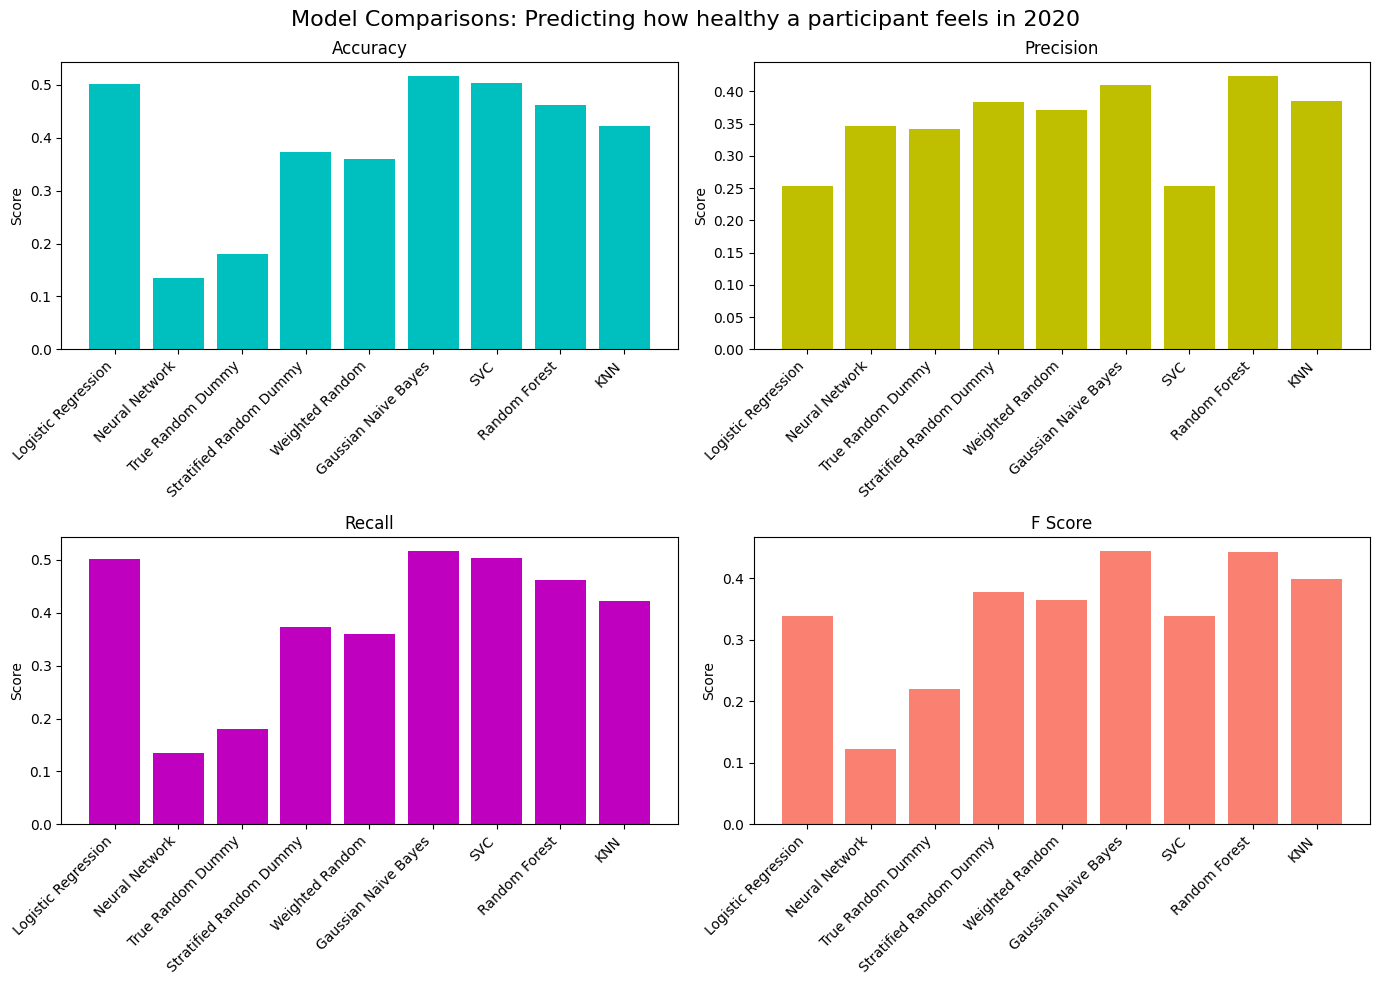

In [46]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Neural Network', 'True Random Dummy', 
          'Stratified Random Dummy', 'Weighted Random', 'Gaussian Naive Bayes', 
          'SVC', 'Random Forest', 'KNN']

accuracy = [0.502, 0.135, 0.181, 0.373, 0.360, 0.517, 0.504, 0.463, 0.423]
precision = [0.254, 0.347, 0.342, 0.383, 0.372, 0.410, 0.254, 0.424, 0.385]
recall = [0.502, 0.135, 0.181, 0.373, 0.360, 0.517, 0.504, 0.463, 0.423]
f_score = [0.338, 0.122, 0.220, 0.377, 0.365, 0.444, 0.338, 0.442, 0.399]


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# add overall title
fig.suptitle('Model Comparisons: Predicting how healthy a participant feels in 2020', fontsize=16)

# Plot Accuracy
axs[0, 0].bar(models, accuracy, color='c')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Score')

# Plot Precision
axs[0, 1].bar(models, precision, color='y')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Score')

# Plot Recall
axs[1, 0].bar(models, recall, color='m')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Score')

# Plot F Score
axs[1, 1].bar(models, f_score, color='salmon')
axs[1, 1].set_title('F Score')
axs[1, 1].set_ylabel('Score')

# Rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()



/var/folders/br/556vkbgd3sx0dxk5j3rczcy80000gn/T/ipykernel_25306/3497982648.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


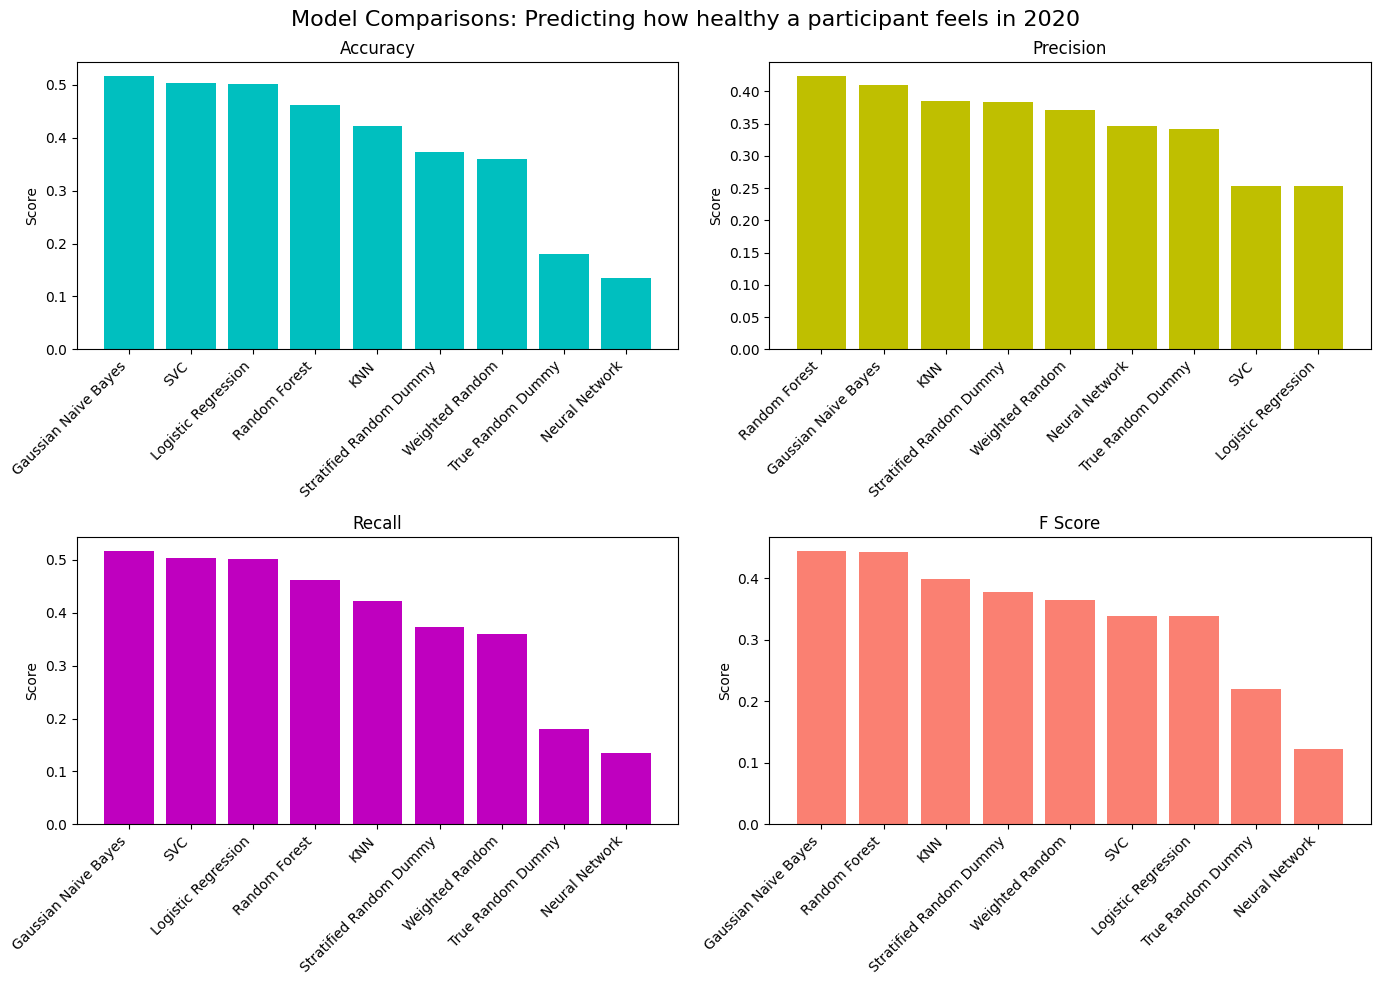

In [47]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Neural Network', 'True Random Dummy', 
          'Stratified Random Dummy', 'Weighted Random', 'Gaussian Naive Bayes', 
          'SVC', 'Random Forest', 'KNN']

accuracy = [0.502, 0.135, 0.181, 0.373, 0.360, 0.517, 0.504, 0.463, 0.423]
precision = [0.254, 0.347, 0.342, 0.383, 0.372, 0.410, 0.254, 0.424, 0.385]
recall = [0.502, 0.135, 0.181, 0.373, 0.360, 0.517, 0.504, 0.463, 0.423]
f_score = [0.338, 0.122, 0.220, 0.377, 0.365, 0.444, 0.338, 0.442, 0.399]


# Sort the models based on each metric
sorted_models_accuracy = [x for _, x in sorted(zip(accuracy, models), reverse=True)]
sorted_accuracy = sorted(accuracy, reverse=True)

sorted_models_precision = [x for _, x in sorted(zip(precision, models), reverse=True)]
sorted_precision = sorted(precision, reverse=True)

sorted_models_recall = [x for _, x in sorted(zip(recall, models), reverse=True)]
sorted_recall = sorted(recall, reverse=True)

sorted_models_f_score = [x for _, x in sorted(zip(f_score, models), reverse=True)]
sorted_f_score = sorted(f_score, reverse=True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# add overall title
fig.suptitle('Model Comparisons: Predicting how healthy a participant feels in 2020', fontsize=16)

# Plot Accuracy
axs[0, 0].bar(sorted_models_accuracy, sorted_accuracy, color='c')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Score')

# Plot Precision
axs[0, 1].bar(sorted_models_precision, sorted_precision, color='y')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Score')

# Plot Recall
axs[1, 0].bar(sorted_models_recall, sorted_recall, color='m')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Score')

# Plot F Score
axs[1, 1].bar(sorted_models_f_score, sorted_f_score, color='salmon')
axs[1, 1].set_title('F Score')
axs[1, 1].set_ylabel('Score')

# Rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_ranked.png')
plt.show()
